In [1]:
import pandas as pd
import numpy as np
import scipy.stats
from sklearn import metrics

trialOrders = {}

import os

path = './events'

def compute_skourascore(subject_performace, idealized_performance):
    return scipy.stats.pearsonr(subject_performace, idealized_performance)[0]

def compute_auc_score(counterbalanced_angles, length):
    score = metrics.auc(np.arange(length * 1.0), counterbalanced_angles) / metrics.auc(np.arange(length * 1.0), np.full((length, 1), 90))
    return score

def compute_peak_score(counterbalanced_angles):
    return np.amax(counterbalanced_angles)

def compute_ttp_score(counterbalanced_angles):
    return np.argmax(counterbalanced_angles)

def find_empty_times(data):
    intermissions = data[data['instruction']==" Push Button"].index.tolist()
    rests = data[data['instruction']==" Rest"]
    first_scan_index = data[data['instruction']!=" Rest"].index.tolist()[0] - 1
    first_rest_at_end = data[data['instruction']!=" Rest"].index.tolist()[-1] + 1
    times = [first_scan_index] + intermissions + [first_rest_at_end]
    return times

def determine_trialorder(data, times):
    trialOrder = []
    for trialnum in range(12):
        this_trial = data[(times[trialnum] + 1):times[trialnum + 1]][data['feedback']=="On"]
        trialOrder += [this_trial['left_text'].tolist()[0][1:] + "-" + this_trial['right_text'].tolist()[0][1:], this_trial['instruction'].tolist()[0][1:]]
    return trialOrder

files = []
# r=root, d=directories, f = files
for r, d, f in os.walk(path):
    for file in f:
        if '.tsv' in file:
            files.append(os.path.join(r, file))
            

In [2]:
import copy
means_template = {'ID':[], 'down': [], 'up': [], 'both': []}

series_template = {'ID':[]}
for i in range(1, 13):
    series_template[str(i)] = []

downseries_template = {'ID':[]}
for i in range(1, 7):
    downseries_template[str(i)] = []
    
upseries_template = {'ID':[]}
for i in range(1, 7):
    upseries_template[str(i)] = []

skouradict = {'means':copy.deepcopy(means_template), 'series':copy.deepcopy(series_template), 'downseries':copy.deepcopy(downseries_template), 'upseries': copy.deepcopy(upseries_template)}
aucdict = {'means':copy.deepcopy(means_template), 'series':copy.deepcopy(series_template), 'downseries':copy.deepcopy(downseries_template), 'upseries': copy.deepcopy(upseries_template)}
peakdict = {'means':copy.deepcopy(means_template), 'series':copy.deepcopy(series_template), 'downseries':copy.deepcopy(downseries_template), 'upseries': copy.deepcopy(upseries_template)}
ttpdict = {'means':copy.deepcopy(means_template), 'series':copy.deepcopy(series_template), 'downseries':copy.deepcopy(downseries_template), 'upseries': copy.deepcopy(upseries_template)}

for i in range(len(files)):
    #parsing filename to find NKI subject ID
    subpos = files[i].find('sub-A')
    subjID = files[i][(subpos + 4):(subpos + 13)]
    #reading events.tsv file as "data"
    data = pd.read_csv(files[i], sep="\t")
    times = find_empty_times(data)
    trialOrder = determine_trialorder(data, times)
    
    skouradict['series']['ID'] += [subjID]
    skouradict['upseries']['ID'] += [subjID]
    skouradict['downseries']['ID'] += [subjID]
    
    aucdict['series']['ID'] += [subjID]
    aucdict['upseries']['ID'] += [subjID]
    aucdict['downseries']['ID'] += [subjID]
    
    peakdict['series']['ID'] += [subjID]
    peakdict['upseries']['ID'] += [subjID]
    peakdict['downseries']['ID'] += [subjID]
    
    ttpdict['series']['ID'] += [subjID]
    ttpdict['upseries']['ID'] += [subjID]
    ttpdict['downseries']['ID'] += [subjID]
    
    series_position = 1
    downseries_position = 1
    upseries_position = 1
    
    for trialnum in range(12):
        #this_trial is the data just from the trial of trialnum
        #this_trial is set to the FIRST 15 TRs (first 30 seconds) of each trial!
        this_trial = data[(times[trialnum] + 1):times[trialnum + 1]]#[0:16]
        length = len(this_trial.needle_position.values)
        instruction = trialOrder[(trialnum * 2) + 1]
        polarity = trialOrder[(trialnum * 2)]
        if instruction == "Focus":
            if polarity == 'Focused-Wandering':
                idealized = np.linspace(90, 90 + (length - 1), num=length)
                auc_balanced = (this_trial.needle_position.values - 90)
            elif polarity == 'Wandering-Focused':
                idealized = np.linspace(90, 90 - (length - 1), num=length)
                auc_balanced = (this_trial.needle_position.values - 90) * -1
            
            #calculating scores
            auc = compute_auc_score(auc_balanced, length)
            skourascore = compute_skourascore(this_trial.needle_position.values, idealized)
            peak = compute_peak_score(auc_balanced)
            ttp = compute_ttp_score(auc_balanced)
            
            #storing scores in memory
            skouradict['downseries'][str(downseries_position)] += [skourascore]
            aucdict['downseries'][str(downseries_position)] += [auc]
            peakdict['downseries'][str(downseries_position)] += [peak]
            ttpdict['downseries'][str(downseries_position)] += [ttp]
            
            downseries_position += 1
        elif instruction == "Wander":
            if polarity == 'Focused-Wandering':
                idealized = np.linspace(90, 90 - (length - 1), num=length)
                auc_balanced = (this_trial.needle_position.values - 90) * -1
            elif polarity == 'Wandering-Focused':
                idealized = np.linspace(90, 90 + (length - 1), num=length)
                auc_balanced = (this_trial.needle_position.values - 90)
            
            #calculating scores
            auc = compute_auc_score(auc_balanced, length)
            skourascore = compute_skourascore(this_trial.needle_position.values, idealized)
            peak = compute_peak_score(auc_balanced)
            ttp = compute_ttp_score(auc_balanced)
            
            #storing scores in memory
            skouradict['upseries'][str(upseries_position)] += [skourascore]
            aucdict['upseries'][str(upseries_position)] += [auc]
            peakdict['upseries'][str(upseries_position)] += [peak]
            ttpdict['upseries'][str(upseries_position)] += [ttp]
            
            upseries_position += 1
        else:
            print("something is horribly wrong")
        skouradict['series'][str(series_position)] += [skourascore]
        aucdict['series'][str(series_position)] += [auc]
        peakdict['series'][str(series_position)] += [peak]
        ttpdict['series'][str(series_position)] += [ttp]
        
        series_position += 1

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


In [3]:
#convert series dicts into dataframes
#first skourascores
skouraseries = pd.DataFrame(skouradict['series'])
skouradownseries = pd.DataFrame(skouradict['downseries'])
skouraupseries = pd.DataFrame(skouradict['upseries'])
#now AUC scores
aucseries = pd.DataFrame(aucdict['series'])
aucdownseries = pd.DataFrame(aucdict['downseries'])
aucupseries = pd.DataFrame(aucdict['upseries'])
#now peak scores
ttpseries = pd.DataFrame(ttpdict['series'])
ttpdownseries = pd.DataFrame(ttpdict['downseries'])
ttpupseries = pd.DataFrame(ttpdict['upseries'])
#now TTP scores
peakseries = pd.DataFrame(peakdict['series'])
peakdownseries = pd.DataFrame(peakdict['downseries'])
peakupseries = pd.DataFrame(peakdict['upseries'])

#now sort them by IDs
skouraseries.sort_values(by=['ID'])
skouradownseries.sort_values(by=['ID'])
skouraupseries.sort_values(by=['ID'])
aucseries.sort_values(by=['ID'])
aucdownseries.sort_values(by=['ID'])
aucupseries.sort_values(by=['ID'])
ttpseries.sort_values(by=['ID'])
ttpdownseries.sort_values(by=['ID'])
ttpupseries.sort_values(by=['ID'])
peakseries.sort_values(by=['ID'])
peakdownseries.sort_values(by=['ID'])
peakupseries.sort_values(by=['ID'])
None;

Function for calculating skouras-style "learning" score. "learning" in this context is measured as the average of trials 4-6 minus the average of trials 1-3. This "learning" measurement is independent of score-type, and can be calculated for each one.

It also calculates the 6-1 learning measure.

I define a function for calculating "learning" here.

In [4]:
#this function assumes a trial-series of length 6 (either up or down regulation, but not both)
def add_learning_measures(series):
    series['first_avg'] = series[['1', '2','3']].mean(axis=1)
    series['second_avg'] = series[['4', '5','6']].mean(axis=1)
    series['skouras_learning'] = series['second_avg'] - series['first_avg']
    series['six_minus_one'] = series['6'] - series['1']
    series['difference_between_measures'] = series['six_minus_one'] - series['skouras_learning']
    return series

In [5]:
%matplotlib notebook

Create function for plotting learning curves and histograms of arbitrary # of trials

In [6]:
import matplotlib
import matplotlib.pyplot as plt
from scipy import stats

def learningcurve(seriesdata, length, scoretype):
    x = []
    for i in range(length):
        x += [i + 1]

    series = pd.DataFrame(seriesdata)
    series = series.sort_values(by=['ID'])
    series = series.to_numpy()
    fig, ax = plt.subplots(2, 1)
    diffs = []
    for j in range(len(series)):
        x=np.asarray(x).astype(np.float)
        ax[0].scatter(x, series[j][1:], color='b', alpha=0.1)
        diffs += [series[j][6] - series[j][1]]
        y = series[j][1:].astype(np.float)
        slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
        z = np.polyfit(x, y, 1)
        p = np.poly1d(z)
        ax[0].plot(x,p(x),"r", alpha=0.2)
    ax[1].hist(diffs, 4)
    # set ticks and tick labels
    ax[0].set_xlim((1, length))
    ax[0].set_xticks(x)
    ax[0].set_xticklabels(x)

    plt.xlabel('Trial Position (not the actual trial number)')
    plt.ylabel('Score')
    plt.title(scoretype + ' learning curves')
    plt.tight_layout()

    plt.show()
    
def series_histogram(seriesdata, scoretype, length, n_bins):
    series = pd.DataFrame(seriesdata)
    series = series.sort_values(by=['ID'])

    fig, axs = plt.subplots(length, 1, sharey=True, sharex=True)
    for trialPos in range(length):
        axs[trialPos].hist(series[str(trialPos + 1)].to_list(), bins=n_bins)
        axs[trialPos].set_title(scoretype + ' Trial ' + str(trialPos + 1))
    plt.xlabel('Score')
    plt.tight_layout()
    plt.show()

AUC score
Average difference between measures = 0.07292300752328128
skouras_learning measure has a variance of 0.05376020462044206
6-1 measure has a variance of 0.11361391997136126
Here is a random sample of 10 subjects.
     skouras_learning  six_minus_one  difference_between_measures
61           0.271774       0.080334                    -0.191439
36           0.235204       0.587108                     0.351904
25           0.246116       0.095737                    -0.150379
40           0.047202       0.251077                     0.203875
54           0.068356      -0.117603                    -0.185959
97           0.047228      -0.769333                    -0.816561
85          -0.128188       0.018640                     0.146828
39           0.289189       0.585713                     0.296524
128          0.148642       0.305171                     0.156529
55           0.100583       0.353380                     0.252797


<IPython.core.display.Javascript object>


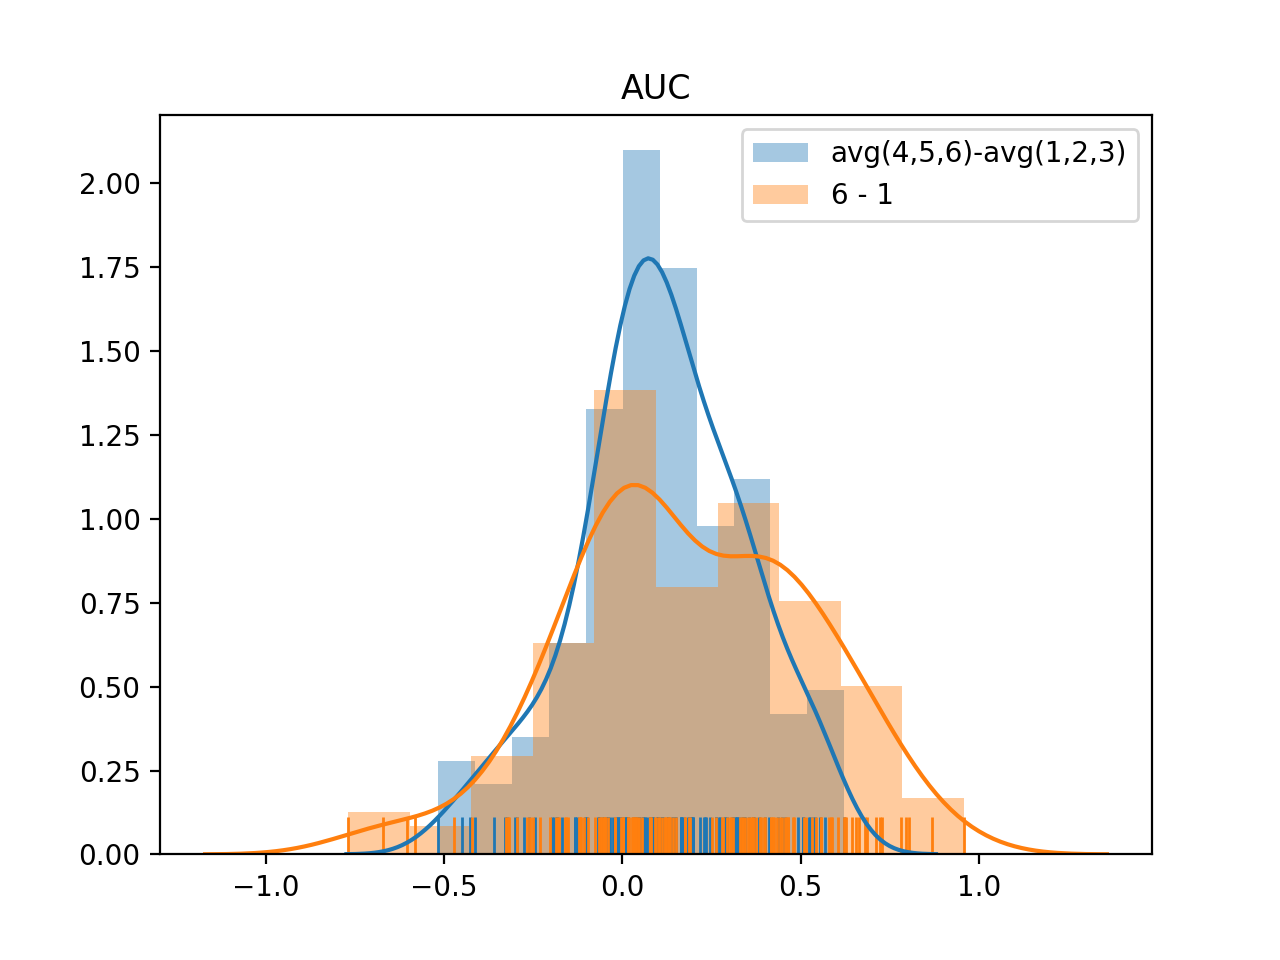

Skouras-Score score
Average difference between measures = 0.16380145205968166
skouras_learning measure has a variance of 0.3380568906533712
6-1 measure has a variance of 0.8905231804719707
Here is a random sample of 10 subjects.
     skouras_learning  six_minus_one  difference_between_measures
91          -0.403032       0.028610                     0.431642
2            0.901719      -0.050816                    -0.952535
10           0.374652       1.789481                     1.414829
17           0.183452      -0.581261                    -0.764713
99           0.397783       1.505303                     1.107520
1            0.572758       1.737952                     1.165195
58           0.653794       0.421905                    -0.231890
52          -0.008570       1.501677                     1.510247
26          -0.328337       1.170855                     1.499192
123          0.254308      -0.866589                    -1.120897


<IPython.core.display.Javascript object>


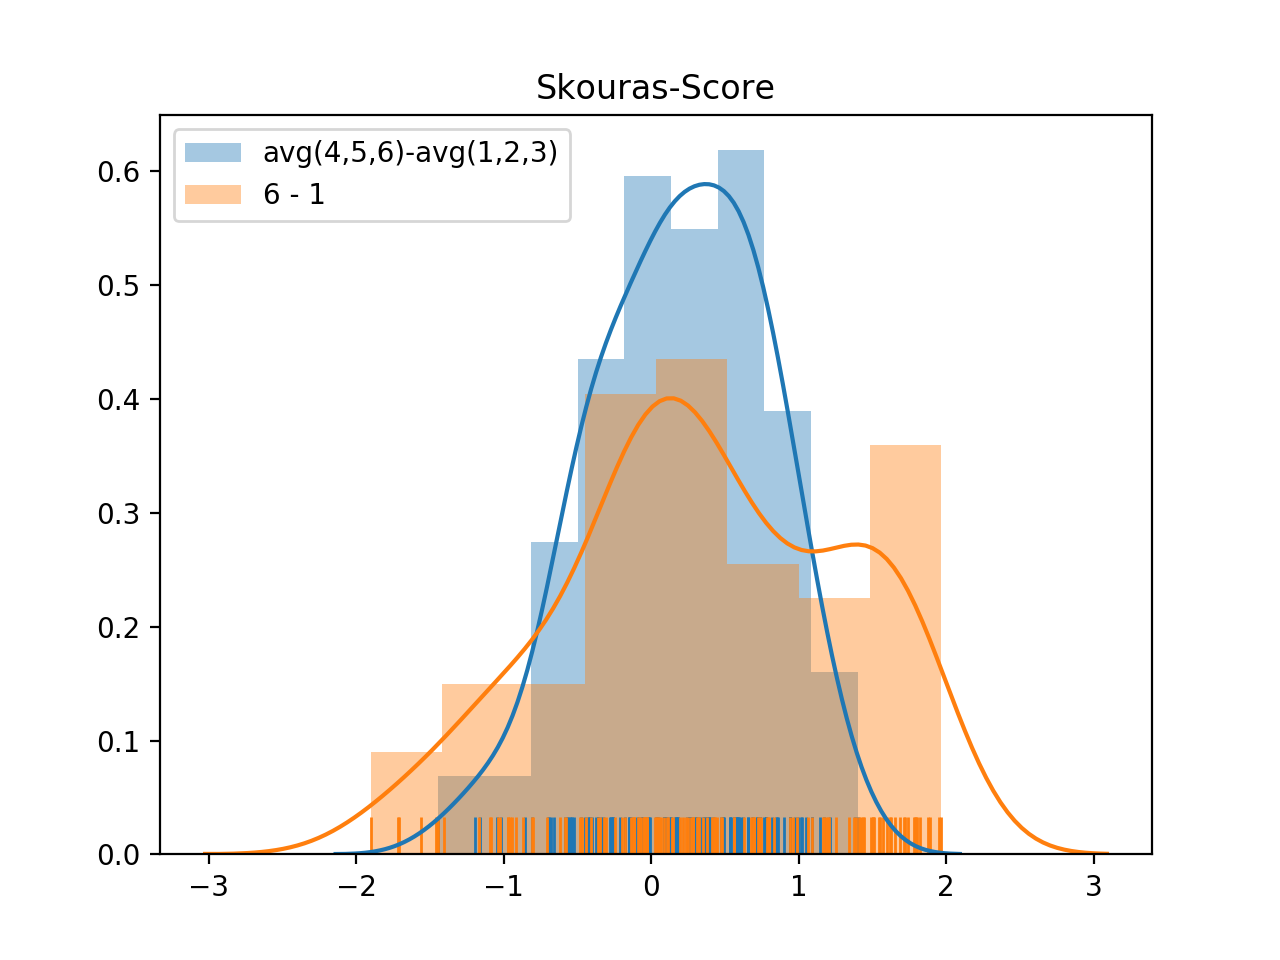

Time-to-peak score
Average difference between measures = -1.9927536231884058
skouras_learning measure has a variance of 66.47574039067423
6-1 measure has a variance of 459.1031821045999
Here is a random sample of 10 subjects.
     skouras_learning  six_minus_one  difference_between_measures
36          -2.000000             34                    36.000000
44         -17.000000            -39                   -22.000000
27          -4.333333             23                    27.333333
35           3.666667             -1                    -4.666667
103         -6.000000            -12                    -6.000000
23         -10.000000            -34                   -24.000000
40          -4.333333            -30                   -25.666667
3            3.666667             13                     9.333333
97          -9.666667            -36                   -26.333333
1            2.666667             18                    15.333333


<IPython.core.display.Javascript object>


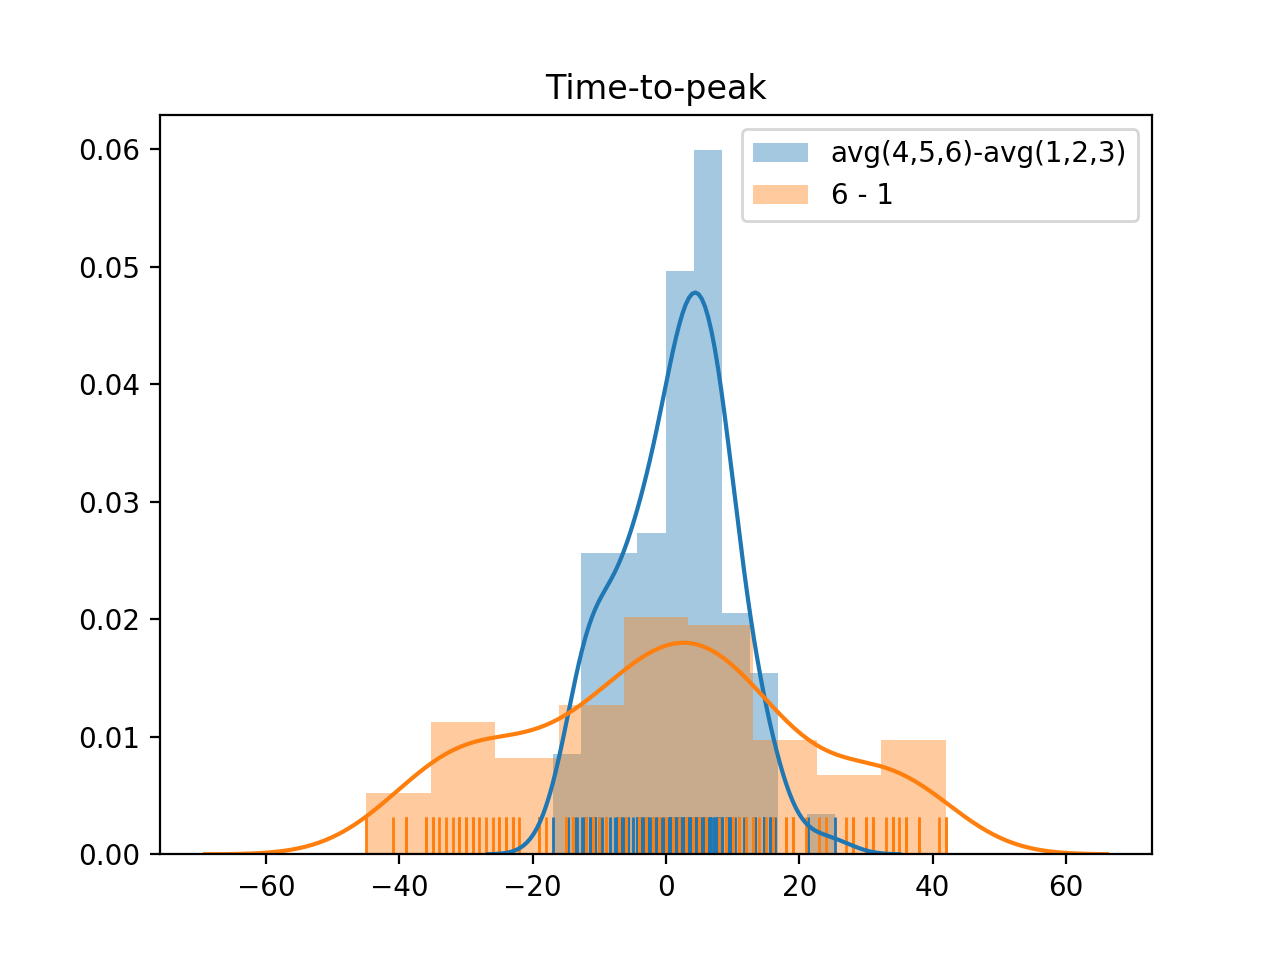

Peak score
Average difference between measures = 12.88526811594203
skouras_learning measure has a variance of 474.5868717101449
6-1 measure has a variance of 1478.3184356744907
Here is a random sample of 10 subjects.
     skouras_learning  six_minus_one  difference_between_measures
92          -6.224333         19.173                    25.397333
18          45.811667         62.221                    16.409333
51         -40.276333        -33.338                     6.938333
77          18.004000          6.155                   -11.849000
117         40.726667         84.685                    43.958333
89          14.904333         13.929                    -0.975333
106         40.182667         38.702                    -1.480667
101         43.643667         15.997                   -27.646667
131          6.208000         77.650                    71.442000
26          -2.155000         19.871                    22.026000


<IPython.core.display.Javascript object>


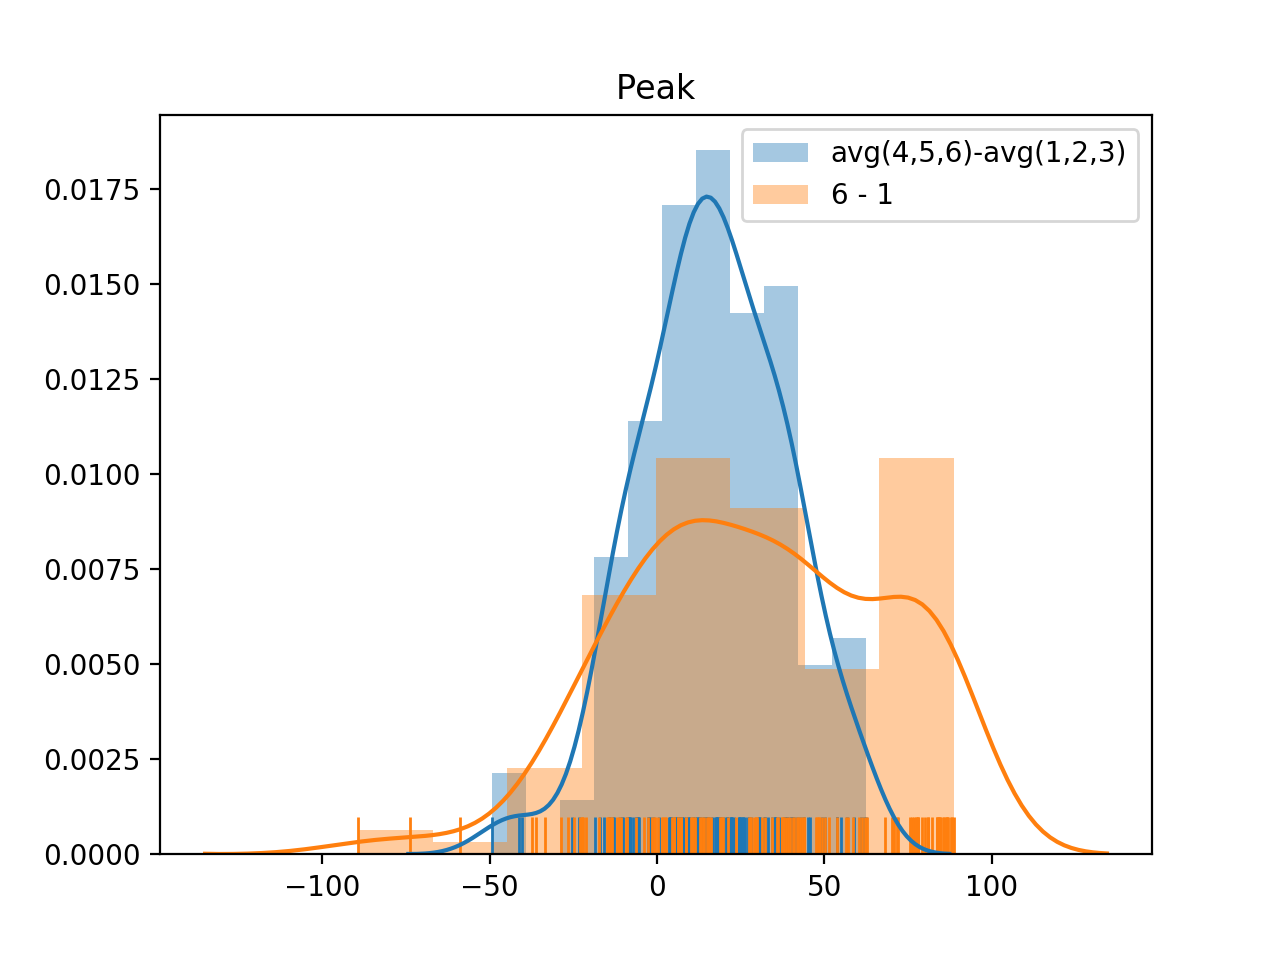

In [7]:
%matplotlib notebook
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt

def learning_hist(series, title, dosample=False):
    if dosample:
        print(title, "score")
        print("Average difference between measures =", series['difference_between_measures'].mean(axis=0))
        print('skouras_learning measure has a variance of', np.var(series[['skouras_learning']].values))
        print('6-1 measure has a variance of', np.var(series[['six_minus_one']].values))
        print("Here is a random sample of 10 subjects.")
        print(series[['skouras_learning','six_minus_one', 'difference_between_measures']].sample(10))
    plt.figure()
    x = series[['skouras_learning']].values
    y = series[['six_minus_one']].values
    sns.distplot(x, kde=True, rug=True, label="avg(4,5,6)-avg(1,2,3)")
    sns.distplot(y, kde=True, rug=True, label="6 - 1")
    plt.legend()
    plt.title(title)
    plt.show()

aucdownserieslearning = add_learning_measures(aucdownseries)
skouradownserieslearning = add_learning_measures(skouradownseries)
ttpdownserieslearning = add_learning_measures(ttpdownseries)
peakdownserieslearning = add_learning_measures(peakdownseries)


learning_hist(aucdownserieslearning, "AUC", dosample=True)
learning_hist(skouradownserieslearning, "Skouras-Score", dosample=True)
learning_hist(ttpdownserieslearning, "Time-to-peak", dosample=True)
learning_hist(peakdownserieslearning, "Peak", dosample=True)

from IPython.core.display import display, HTML
display(HTML("<style>div.output_scroll { height: 250em; }</style>"))

Reading in age and clinical status csv file made in pmetrics.ipynb.

Going to test for interesting correlations with them and the other data.

From skouras:
    In the control group, age (M = 30.71 years; SD = 7.48; nb = 62) correlated negatively with overall DMN NF performance score (M = 0.195, SD = 0.312) with a moderate association that explained 17% of the variance, r(62)=-0.412, R2 = 0.17, P = 0.0009; Fig. 3B.
    
My output:
    In the control group, age ( M = 32.05501195912154  years; SD = 7.8142617590016386 n = 63 ) correlated negatively with overall DMN NF performance score ( M = 0.19537175723329936 SD = 0.2955934924510536 ) with an association that explained 17.79582649049908 % of the variance, r(63) = -0.4218509984639017 R2 = 0.1779582649049908 P = 0.0005741932845391171
    
parameters that matter for correlations    
-whether I use first 30 secs or whole session

-type of scoring method

-type of score aggregation method (learning or overall)

-whether I remove sleepers

-which trials are considered in the aggregation

Lilliefors Test - Ages of all NFB Participants
n= 136 D = 0.1157106553649474 p= 0.0009999999999998899
Lilliefors Test - Ages of control-group NFB Participants
n= 62 D = 0.12486230152487299 p= 0.024628649322041556
Lilliefors Test - Ages of pathological NFB Participants
n= 74 D = 0.13431123744271595 p= 0.0040623504562244655





Comparing ages of control-group with AUC Down overall score
Lilliefors Test AUC Down overall score
n= 62 D = 0.06719512135373151 p= 0.7400269321409972


<IPython.core.display.Javascript object>


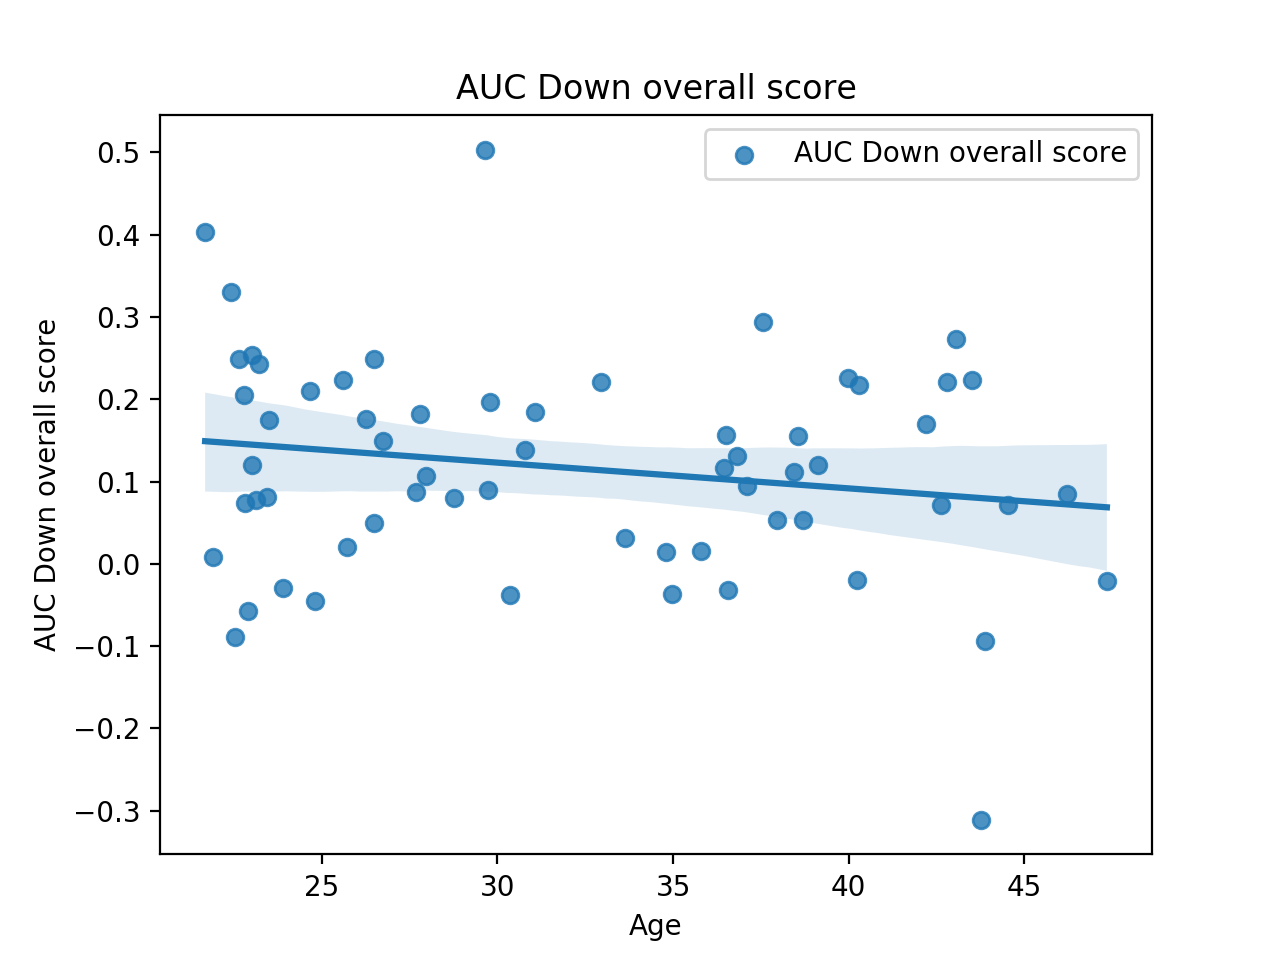

Correlation Tests AUC Down overall score (ran both, since I haven't figured out yet how to check for normal distribution)
Pearson r = -0.18625833115401877 R2 =  0.03469216592428012 p =  0.14720613428609736
Spearman r = -0.1321800005036388 R2 =  0.017471552533141952 p =  0.3057845729489271





Comparing ages of control-group with Skouras overall score
Lilliefors Test Skouras overall score
n= 62 D = 0.12740633785165206 p= 0.02100454012204063


<IPython.core.display.Javascript object>


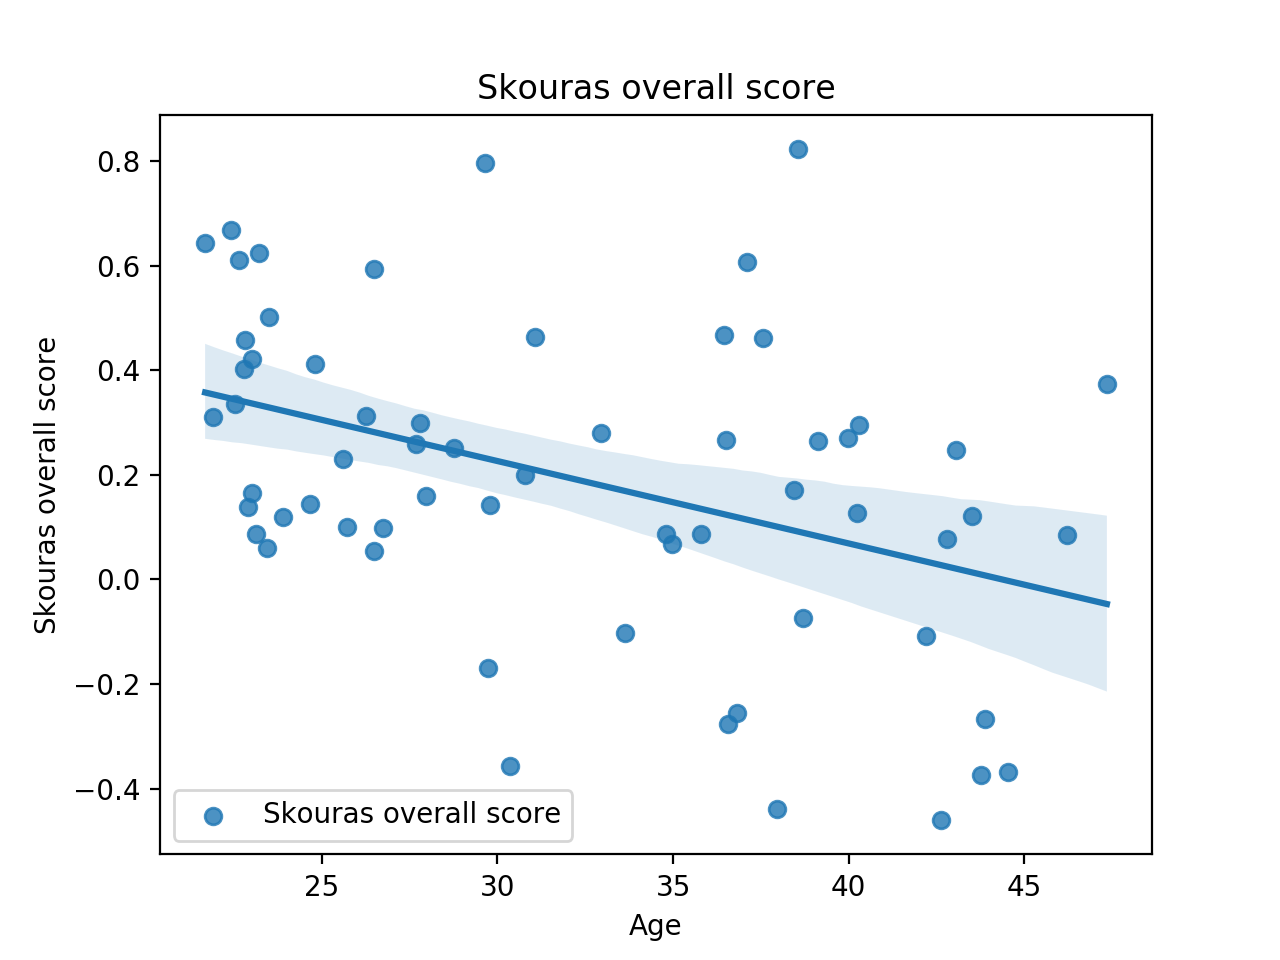

Correlation Tests Skouras overall score (ran both, since I haven't figured out yet how to check for normal distribution)
Pearson r = -0.4094169458248388 R2 =  0.16762223552853897 p =  0.0009522478147549509
Spearman r = -0.4241394072171438 R2 =  0.17989423675451016 p =  0.0005916040757788603





Comparing ages of control-group with AUC overall score
Lilliefors Test AUC overall score
n= 62 D = 0.12677428726546802 p= 0.021904928343759004


<IPython.core.display.Javascript object>


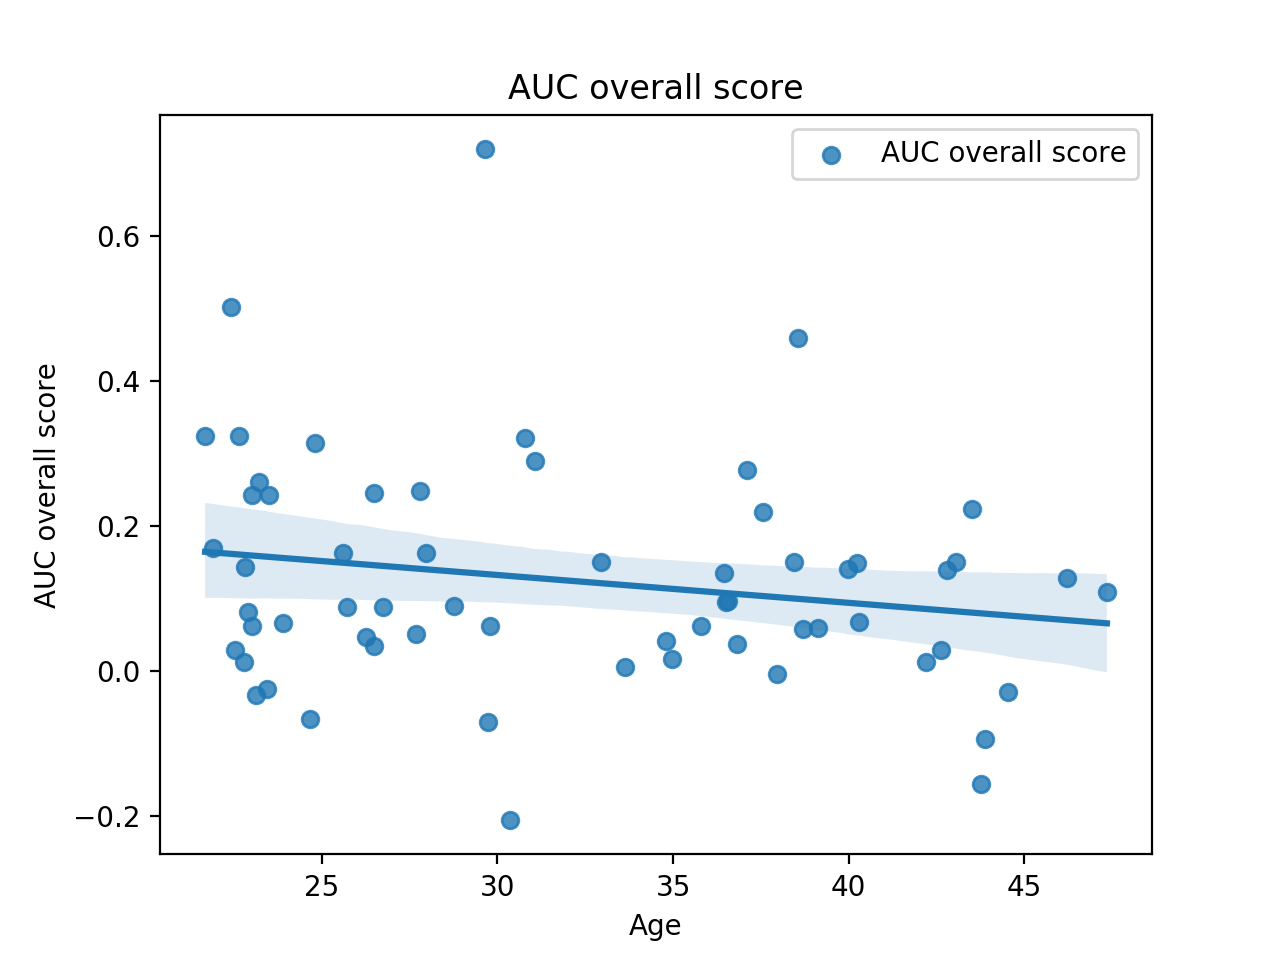

Correlation Tests AUC overall score (ran both, since I haven't figured out yet how to check for normal distribution)
Pearson r = -0.19401272399996383 R2 =  0.03764093707388614 p =  0.13079720312862114
Spearman r = -0.19281811085089776 R2 =  0.03717882387210909 p =  0.13323075488164712


In [8]:
import pandas as pd
import numpy as np
from IPython.display import display, HTML
from IPython.display import display, HTML
from scipy import stats
from scipy.stats import norm
from statsmodels.stats.diagnostic import lilliefors
import seaborn as sns

def lillie(nums, name=""):
    ksstat, pval = lilliefors(nums, pvalmethod='table')
    print("Lilliefors Test " + name)
    print("n=", len(nums), "D =", ksstat, "p=", pval)
    
def compare_with_control_age(othernums, vname="", path=False, exact=True, nosleep=True):
    diags_ages = pd.read_csv('./diags_ages.csv')
    diags_ages = pd.merge(skouraseries[['ID']], diags_ages, how='inner', on='ID').sort_values(by=['ID']).drop_duplicates(subset=['ID']).reset_index(drop=True)
    if nosleep:
        diags_ages = diags_ages[diags_ages['NFB3_MRIQ_01'] == 0].sort_values(by=['ID']).reset_index(drop=True)
        diags_ages = diags_ages[diags_ages['NFB3_MRIQ_02'] == 0].sort_values(by=['ID']).reset_index(drop=True)
    if not path:
        diags_ages_control = diags_ages[diags_ages['DIAG_01#CODE'] == 'V71.09'].sort_values(by=['ID']).reset_index(drop=True)
    else:
        diags_ages_control = diags_ages[diags_ages['DIAG_01#CODE'] != 'V71.09'].sort_values(by=['ID']).reset_index(drop=True)
    
    print("Comparing ages of control-group with " + vname)
    
    if exact:
        diags_ages_control = diags_ages_control[['ID', 'AGE_04']]
    else:
        diags_ages_control = diags_ages_control[['ID', 'AGE']]
    data = pd.merge(othernums, diags_ages_control, how='inner', on='ID').sort_values(by=['ID']).drop_duplicates(subset=['ID']).reset_index(drop=True)
    if exact:
        ages = data.AGE_04.values
    else:
        ages = data.AGE.values
    
    lillie(data[othernums.columns[1]].values, vname)
    
    pr, pp = stats.pearsonr(data[othernums.columns[1]].values, ages)
    sr, sp = stats.spearmanr(data[othernums.columns[1]].values, ages)
    
    x, y = pd.Series(ages, name="Age"), pd.Series(data[othernums.columns[1]].values, name=vname)
    plt.figure()
    ax = sns.regplot(x=x, y=y, label=vname)
    plt.legend()
    plt.title(vname)
    plt.show()
    
    print("Correlation Tests " + vname + " (ran both, since I haven't figured out yet how to check for normal distribution)")
    print("Pearson r =", pr, "R2 = ", pr ** 2, "p = ", pp)
    print("Spearman r =", sr, "R2 = ", sr ** 2, "p = ", sp)

diags_ages = pd.read_csv('./diags_ages.csv')
diags_ages = pd.merge(skouraseries[['ID']], diags_ages, how='inner', on='ID').sort_values(by=['ID']).drop_duplicates(subset=['ID']).reset_index(drop=True)
diags_ages_control = diags_ages[diags_ages['DIAG_01#CODE'] == 'V71.09'].sort_values(by=['ID']).reset_index(drop=True)
diags_ages_path = diags_ages[diags_ages['DIAG_01#CODE'] != 'V71.09'].sort_values(by=['ID']).reset_index(drop=True)


#display(diags_ages)
lillie(diags_ages.AGE_04.values, "- Ages of all NFB Participants")
lillie(diags_ages_control.AGE_04.values, "- Ages of control-group NFB Participants")
lillie(diags_ages_path.AGE_04.values, "- Ages of pathological NFB Participants")

print("\n\n\n\n")
trials = aucdownseries.loc[: , "1":"6"]
aucdownseries['scores'] = trials.mean(axis=1)
scores_only = aucdownseries[['ID', 'scores']]
compare_with_control_age(scores_only, "AUC Down overall score", nosleep=False)

print("\n\n\n\n")
trials = skouraseries.loc[: , "6":"12"]
skouraseries['scores'] = trials.mean(axis=1)
scores_only = skouraseries[['ID', 'scores']]
compare_with_control_age(scores_only, "Skouras overall score", nosleep=False)

print("\n\n\n\n")
trials = aucseries.loc[: , "6":"12"]
aucseries['scores'] = trials.mean(axis=1)
scores_only = aucseries[['ID', 'scores']]
compare_with_control_age(scores_only, "AUC overall score", nosleep=False)



